In [1]:
# !pip install sktime==0.11.2 pyts

In [17]:
!pip install sktime==0.11.2 pyts

In [18]:
import numpy as np
from sktime.datasets import load_arrow_head  # univariate dataset
from sklearn.metrics import classification_report
from sktime.utils.plotting import plot_series
from pyts.datasets import fetch_uea_dataset
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested

ModuleNotFoundError: No module named 'sktime.datatypes'

## UNIVARIATE

In [3]:
X_train, y_train = load_arrow_head(split="train", return_X_y=True)
X_test, y_test = load_arrow_head(split="test", return_X_y=True)

In [4]:
X_train # pd.DataFrame with a column for each signal and a pd.Series in each cell

,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...
1,0 -1.774571 1 -1.774036 2 -1.77658...
2,0 -1.866021 1 -1.841991 2 -1.83502...
3,0 -2.073758 1 -2.073301 2 -2.04460...
4,0 -1.746255 1 -1.741263 2 -1.72274...
5,0 -1.982806 1 -1.978861 2 -1.93733...
6,0 -2.083023 1 -2.092058 2 -2.04946...
7,0 -1.633596 1 -1.643175 2 -1.61367...
8,0 -1.717013 1 -1.728059 2 -1.68330...
9,0 -2.245295 1 -2.223850 2 -2.17187...


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

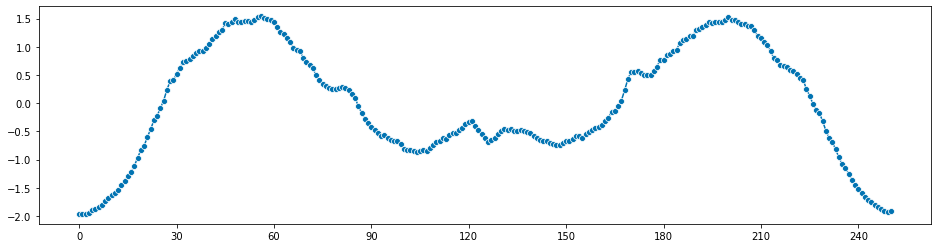

In [5]:
plot_series(X_train["dim_0"][0])

### 1-NN with DTW (baseline)

In [6]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [7]:
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier()

In [8]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        69
           1       0.59      0.72      0.65        53
           2       0.68      0.68      0.68        53

    accuracy                           0.70       175
   macro avg       0.71      0.70      0.70       175
weighted avg       0.72      0.70      0.71       175

CPU times: user 4.72 s, sys: 155 ms, total: 4.87 s
Wall time: 5.62 s


### ROCKET

In [9]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket

In [10]:
%%time
rocket = Rocket()  # by default, MiniRocket uses ~10,000 kernels
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
clf.fit(X_train_transform, y_train)

CPU times: user 2.32 s, sys: 77.2 ms, total: 2.4 s
Wall time: 2.27 s


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [11]:
X_test_transform = rocket.transform(X_test)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.61      0.73        69
           1       0.85      0.94      0.89        53
           2       0.73      0.96      0.83        53

    accuracy                           0.82       175
   macro avg       0.83      0.84      0.82       175
weighted avg       0.84      0.82      0.81       175



### MINI-ROCKET

In [12]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import MiniRocket

In [13]:
%%time
minirocket = MiniRocket()  # by default, MiniRocket uses ~10,000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
clf.fit(X_train_transform, y_train)

CPU times: user 504 ms, sys: 36.9 ms, total: 541 ms
Wall time: 582 ms


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [14]:
X_test_transform = minirocket.transform(X_test)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84        69
           1       0.83      0.92      0.88        53
           2       0.84      0.96      0.89        53

    accuracy                           0.87       175
   macro avg       0.87      0.88      0.87       175
weighted avg       0.88      0.87      0.87       175



### Canonical Interval Forest (CIF)

In [15]:
from sktime.classification.interval_based import CanonicalIntervalForest

In [16]:
%%time
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_train, y_train)

CPU times: user 3min 1s, sys: 16.6 s, total: 3min 17s
Wall time: 4min 13s


CanonicalIntervalForest(n_estimators=30)

In [17]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84        69
           1       0.72      0.74      0.73        53
           2       0.75      0.79      0.77        53

    accuracy                           0.78       175
   macro avg       0.78      0.78      0.78       175
weighted avg       0.79      0.78      0.78       175



## MULTIVARIATE

In [21]:
X_train, X_test, y_train, y_test = fetch_uea_dataset("Libras", return_X_y=True)

In [22]:
X_train.shape

(180, 2, 45)

to convert to and from np arrays:
`sktime.datatypes._panel._convert.from_3d_numpy_to_nested`
`sktime.datatypes._panel._convert.from_nested_to_3d_numpy`
with the np array -> (n_instances, n_columns, n_timepoints)

In [23]:
X_train = from_3d_numpy_to_nested(X_train)
X_test = from_3d_numpy_to_nested(X_test)

In [24]:
X_train

,var_0,var_1
0,0 0.67892 1 0.68085 2 0.68085 3 ...,0 0.27315 1 0.27315 2 0.27315 3 ...
1,0 0.72147 1 0.72340 2 0.72340 3 ...,0 0.23611 1 0.23611 2 0.23611 3 ...
2,0 0.67118 1 0.67118 2 0.67311 3 ...,0 0.38426 1 0.38657 2 0.38657 3 ...
3,0 0.71567 1 0.71373 2 0.70986 3 ...,0 0.68056 1 0.68056 2 0.68981 3 ...
4,0 0.77756 1 0.77563 2 0.77369 3 ...,0 0.63426 1 0.63426 2 0.61806 3 ...
...,...,...
175,0 0.61122 1 0.61122 2 0.61315 3 ...,0 0.75926 1 0.75694 2 0.75694 3 ...
176,0 0.65957 1 0.65764 2 0.65957 3 ...,0 0.79167 1 0.78704 2 0.78935 3 ...
177,0 0.64023 1 0.64217 2 0.64217 3 ...,0 0.71991 1 0.71759 2 0.71759 3 ...
178,0 0.65957 1 0.65764 2 0.65957 3 ...,0 0.79167 1 0.78704 2 0.78935 3 ...


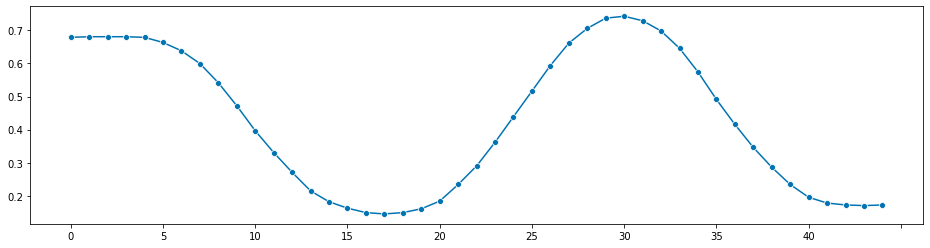

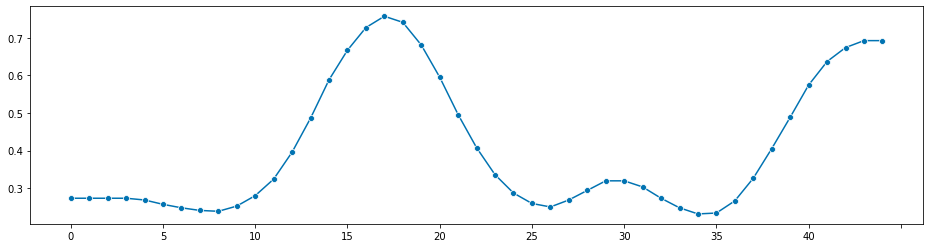

In [25]:
for dim in X_train.columns:
    plot_series(X_train[dim][0])  # plot each signal of the mts

### 1-NN with DTW (baseline)

In [26]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [27]:
clf = KNeighborsTimeSeriesClassifier()
clf.fit(X_train, y_train)

KNeighborsTimeSeriesClassifier()

In [28]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.75      0.86        12
           2       0.80      1.00      0.89        12
           3       1.00      1.00      1.00        12
           4       0.92      0.92      0.92        12
           5       1.00      1.00      1.00        12
           6       1.00      0.92      0.96        12
           7       0.91      0.83      0.87        12
           8       0.79      0.92      0.85        12
           9       0.86      1.00      0.92        12
          10       1.00      0.75      0.86        12
          11       0.62      0.67      0.64        12
          12       0.79      0.92      0.85        12
          13       0.56      0.42      0.48        12
          14       1.00      1.00      1.00        12
          15       0.92      1.00      0.96        12

    accuracy                           0.87       180
   macro avg       0.88      0.87      0.87       180
weighted avg       0.88   

### Rocket

In [29]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket

In [30]:
%%time
rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
clf.fit(X_train_transform, y_train)

CPU times: user 2.96 s, sys: 169 ms, total: 3.13 s
Wall time: 3.05 s


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [31]:
X_test_transform = rocket.transform(X_test)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       0.91      0.83      0.87        12
           3       1.00      1.00      1.00        12
           4       0.91      0.83      0.87        12
           5       1.00      0.92      0.96        12
           6       0.85      0.92      0.88        12
           7       1.00      0.92      0.96        12
           8       1.00      0.92      0.96        12
           9       0.92      1.00      0.96        12
          10       1.00      0.67      0.80        12
          11       0.75      1.00      0.86        12
          12       0.80      1.00      0.89        12
          13       1.00      0.75      0.86        12
          14       1.00      1.00      1.00        12
          15       0.75      1.00      0.86        12

    accuracy                           0.91       180
   macro avg       0.93      0.91      0.91       180
weighted avg       0.93   

### MINI-ROCKET

In [32]:
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [33]:
%%time
minirocket = MiniRocketMultivariate()  # by default, MiniRocket uses ~10,000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
clf.fit(X_train_transform, y_train)

CPU times: user 885 ms, sys: 62.8 ms, total: 948 ms
Wall time: 913 ms


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [34]:
X_test_transform = minirocket.transform(X_test)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       0.90      0.75      0.82        12
           5       1.00      0.83      0.91        12
           6       0.79      0.92      0.85        12
           7       1.00      1.00      1.00        12
           8       1.00      0.83      0.91        12
           9       0.92      1.00      0.96        12
          10       1.00      0.67      0.80        12
          11       0.85      0.92      0.88        12
          12       0.75      1.00      0.86        12
          13       0.83      0.83      0.83        12
          14       0.92      1.00      0.96        12
          15       0.77      0.83      0.80        12

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.90       180
weighted avg       0.92   